## GENERATIVE MODEL (VARIATIONAL AUTOENCODER)
An autoencoder is made up of two parts,encoder and decoder. 

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install keras==2.2.4

In [3]:
#IMPORTING
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import cv2

In [13]:
!unzip /content/drive/MyDrive/CP_GEN-AE/imgs.zip

Archive:  /content/drive/MyDrive/CP_GEN-AE/imgs.zip
replace __MACOSX/._imgs? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import os 
import matplotlib.pyplot as plt 
import cv2 
import numpy as np 
from tqdm import tqdm
punk_data = []
for img in tqdm(os.listdir('/content/imgs')):
    path = '/content/imgs/{}'.format(img)    
    image = plt.imread(path)
    image = image.astype('float32')
    image = image
    punk_data.append(image) 
punk_data = np.array(punk_data)

100%|██████████| 10000/10000 [00:00<00:00, 10727.15it/s]


In [5]:
print(punk_data.shape)

(10000, 24, 24, 4)


In [6]:
import keras

from keras.models import Sequential, Model, Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPool2D, AvgPool2D
from keras.layers import UpSampling2D
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Add, Multiply
from keras.losses import mse, binary_crossentropy
import keras.backend as K

Using TensorFlow backend.


In [7]:
np.random.seed(20)
#NUMBER OF DIMENSIONS IN THE LATENT SPACE
latent_dims = 576

## Building the encoder

The encoder compresses the image via a series of convolutions into a smaller dimensional space (z).

The output is split into 2 blocks, the mean (mu) and log_variance (log_var), which are then recombined to predict a distribution rather than a value.

In [8]:
encoder_in = Input(shape=(24,24,4))  

encoder_l1 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same',name = 'c11', input_shape=(24,24,4))(encoder_in)
encoder_l1 = BatchNormalization(name = '1b1')(encoder_l1)
encoder_l1 = LeakyReLU(0.2,name = '1r1')(encoder_l1)

encoder_l1 = Conv2D(filters=64, kernel_size=5, strides=2, padding='same',name = 'c12')(encoder_l1)
encoder_l1 = BatchNormalization(name = 'b12')(encoder_l1)
encoder_l1 = LeakyReLU(0.2,name = 'r12')(encoder_l1)


encoder_l2 = Conv2D(filters=128, kernel_size=5, strides=2, padding='same',name = 'c13')(encoder_l1)
encoder_l2 = BatchNormalization(name = 'b13')(encoder_l2)
encoder_l2 = LeakyReLU(0.2,name = 'r13')(encoder_l2)

encoder_l3 = Conv2D(filters=256, kernel_size=5, strides=2, padding='same',name = 'c14')(encoder_l2)
encoder_l3 = BatchNormalization(name = 'b14')(encoder_l3)
encoder_l3 = LeakyReLU(0.2,name = 'r14')(encoder_l3)


encoder_l4 = Conv2D(filters=512, kernel_size=5, strides=2, padding='same',name = 'c15')(encoder_l3)
encoder_l4 = BatchNormalization(name = 'b15')(encoder_l4)
encoder_l4 = LeakyReLU(0.2,name = 'r15')(encoder_l4)

flatten = Flatten(name = 'r125')(encoder_l4)

encoder_dense = Dense(1024)(flatten)
encoder_dense = BatchNormalization(name = 'br15')(encoder_dense)
encoder_out = LeakyReLU(0.2,name = 'r1115')(encoder_dense)


mu = Dense(latent_dims)(encoder_out)
log_var = Dense(latent_dims)(encoder_out)


epsilon = Input(tensor=K.random_normal(shape=(K.shape(mu)[0], latent_dims)))  ##INPUT EPSILON FOR RANDOM SAMPLING

sigma = Lambda(lambda x: K.exp(0.5 * x))(log_var) # CHANGE log_var INTO STANDARD DEVIATION(sigma)
z_eps = Multiply()([sigma, epsilon])

z = Add()([mu, z_eps])

encoder=Model([encoder_in,epsilon], z)
encoder.summary()













__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 24, 4)    0                                            
__________________________________________________________________________________________________
c11 (Conv2D)                    (None, 24, 24, 32)   3232        input_1[0][0]                    
__________________________________________________________________________________________________
1b1 (BatchNormalization)        (None, 24, 24, 32)   128         c11[0][0]                        
__________________________________________________________________________________________________
1r1 (LeakyReLU)                 (None, 24, 24, 32)   0           1b1[0][0]                        
_________________________________________________________________________________________________

## Building a Decoder

In [9]:
decoder = Sequential()
decoder.add(Dense(1024, input_shape=(latent_dims,)))
decoder.add(BatchNormalization(name = 'b1'))
decoder.add(LeakyReLU(0.2,name = 'r1'))

decoder.add(Dense(2048))
decoder.add(BatchNormalization(name = 'b2'))
decoder.add(LeakyReLU(0.2,name = 'r2'))

decoder.add(Reshape(target_shape=(2,2,512)))

decoder.add(Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same',name = 'c1'))
decoder.add(BatchNormalization(name = 'b3'))
decoder.add(LeakyReLU(0.2,name = 'r3'))

decoder.add(Conv2DTranspose(filters=128, kernel_size=5, strides=3, padding='same',name = 'c2'))
decoder.add(BatchNormalization(name = 'b4'))
decoder.add(LeakyReLU(0.2,name = 'r4'))

decoder.add(Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same',name = 'c3'))
decoder.add(BatchNormalization(name = 'b5'))
decoder.add(LeakyReLU(0.2,name = 'r5'))

decoder.add(Conv2DTranspose(filters=32, kernel_size=5, strides=1, padding='same',name = 'c33'))
decoder.add(BatchNormalization(name = 'b35'))
decoder.add(LeakyReLU(0.2,name = 'r35'))

decoder.add(Conv2DTranspose(filters=4, kernel_size=5,activation = 'sigmoid',strides=1, padding='same',name = 'c5'))
decoder.add(BatchNormalization(name = 'b7'))
decoder.add(Activation('sigmoid'))

decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              590848    
_________________________________________________________________
b1 (BatchNormalization)      (None, 1024)              4096      
_________________________________________________________________
r1 (LeakyReLU)               (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
b2 (BatchNormalization)      (None, 2048)              8192      
_________________________________________________________________
r2 (LeakyReLU)               (None, 2048)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
__________

## Full Variational Autoencoder

In [10]:
# COMBINING ENCODER AND DECODER TO COMPLETE THE VARIATIONAL AUTO ENCODER

vae_preds = decoder(z)
vae = Model([encoder_in, epsilon], vae_preds)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 24, 4)    0                                            
__________________________________________________________________________________________________
c11 (Conv2D)                    (None, 24, 24, 32)   3232        input_1[0][0]                    
__________________________________________________________________________________________________
1b1 (BatchNormalization)        (None, 24, 24, 32)   128         c11[0][0]                        
__________________________________________________________________________________________________
1r1 (LeakyReLU)                 (None, 24, 24, 32)   0           1b1[0][0]                        
__________________________________________________________________________________________________
c12 (Conv2

## Loss Functions

Reconstruction loss 
* Mean Squared Loss

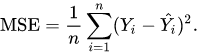

kl_loss
* kullback leibler loss

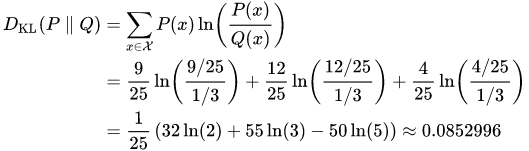

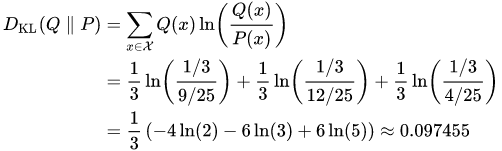

In [11]:
def reconstruction_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

def kl_loss(y_true, y_pred):
    kl_loss = - 0.5 * K.mean(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
    return kl_loss

def vae_loss(y_true, y_pred):
    return reconstruction_loss(y_true, y_pred) + 0.03 * kl_loss(y_true, y_pred)   #scaling kl_loss by 0.03 seem to help


In [12]:
c = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
vae.compile(optimizer='adam', loss=vae_loss , metrics=[reconstruction_loss, kl_loss])

In [ ]:
vae.fit(punk_data,punk_data,epochs=100, batch_size=64)



Epoch 1/100
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1328 - reconstruction_loss: 0.1309 - kl_loss: 0.0645
Epoch 2/100
10000/10000 [==============================] - 5s 550us/step - loss: 0.1013 - reconstruction_loss: 0.0991 - kl_loss: 0.0716
Epoch 3/100
10000/10000 [==============================] - 6s 580us/step - loss: 0.0811 - reconstruction_loss: 0.0787 - kl_loss: 0.0806
Epoch 4/100
10000/10000 [==============================] - 5s 538us/step - loss: 0.0659 - reconstruction_loss: 0.0634 - kl_loss: 0.0843
Epoch 5/100
10000/10000 [==============================] - 6s 585us/step - loss: 0.0549 - reconstruction_loss: 0.0522 - kl_loss: 0.0918
Epoch 6/100
10000/10000 [==============================] - 6s 586us/step - loss: 0.0455 - reconstruction_loss: 0.0430 - kl_loss: 0.0828
Epoch 7/100
10000/10000 [==============================] - 5s 539us/step - loss: 0.0388 - reconstruction_loss: 0.0363 - kl_loss: 0.0819
Epoch 8/100
 9024/10000 [======================

## PREDICTIONS

In [ ]:
def plot_images(rows, cols, images, title):
    grid = np.zeros(shape=(rows*24, cols*24,4))
    for row in range(rows):
        for col in range(cols):
            grid[row*24:(row+1)*24, col*24:(col+1)*24, :] = images[row*cols + col]

    plt.figure(figsize=(40,40))       
    plt.imshow(grid)
    plt.title(title)
    plt.show()

## ORIGINAL FACES

In [ ]:
predictions = punk_data[:200]
plot_images(20,8,predictions,"ORIGINAL FACES")

## RECONSTRUCTED FACES or COMPRESSED (*which tries to replicate the original images*)

In [ ]:
predictions  = vae.predict(punk_data[:200])
plot_images(20,8,predictions, "RECONSTRUCTED FACES")

## NEWLY GENERATED FACES

In [ ]:
predictions= decoder.predict(np.random.randn(200, latent_dims))
plot_images(20,8,predictions, "GENERATED FACES (NEW FACES)")

In [ ]:
decoder.save('decoder576final_punk.h5')

In [ ]:
vae.save('encoder5_punk.h5')

In [ ]:
import matplotlib.pyplot as plt 

images = decoder.predict(np.random.randn(1, latent_dims))
plt.imshow(images[0])
# images.shape

In [ ]:
la = encoder.predict(punk_data[:])

In [ ]:
import pickle as pkl 
pkl.dump(la, open('latent_punk.pkl','wb'))

## Conclusion

Our model has generated the images. Perhaps, I can improve the quality of predictions by adding a lot more encoding and decoding layers. VARIATIONAL AUTOENCODERS ARE GENERATIVE MODELS. THIS SHOWS US HOW CREATIVE A DEEP LEARNING MODEL CAN BE!
